In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import time
def timer(func):
    def wrapper(*args,**kwargs):
        start = time.time()
        result = func(*args,**kwargs)
        end = time.time()
        print(func.__name__+'运行时间：',end-start)
        return result
    return wrapper

### date+week 0.61 0.55

In [14]:
%%time
data_date = joblib.load('../../scrum_data/train_data/train_date.lz4')
data_week =joblib.load('../../scrum_data/train_data/train_week.lz4')
data = pd.concat([data_date,data_week],axis=1,copy=False)
data_label = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
x_df = data.fillna(-1)
y = data_label.values.ravel()
x_df.shape

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 16 ms


### null+null_sign 
train: 0.998 0.68  
cv: 0.7

In [22]:
%%time
data_null = joblib.load('../../scrum_data/train_data/train_null.lz4')
data_null_sign = joblib.load('../../scrum_data/train_data/train_null_sign90.lz4')
data = pd.concat([data_null,data_null_sign],axis=1)
data_label = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
x_df = data.fillna(-1)
y = data_label.values.ravel()
x_df.shape

CPU times: user 112 ms, sys: 16 ms, total: 128 ms
Wall time: 209 ms


## maj+majcnt 1.0 0.8

In [22]:
data_maj = joblib.load('../../scrum_data/train_data/train_maj.lz4')
data_majcnt = joblib.load('../../scrum_data/train_data/train_majcnt.lz4')
data = pd.concat([data_maj,data_majcnt],axis=1,copy=False)
data_label = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
x_df = data.fillna(-1)
y = data_label.values.ravel()
x_df.shape

(33465, 4632)

### cross_feature 
train: 1.0  0.837  
cv: 0.838

In [17]:
data_cf_fs = joblib.load('../../scrum_data/train_data/train_cf_86_fs10.lz4')
data = data_cf_fs
data_label = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
x_df = data.fillna(-1)
y = data_label.values.ravel()
x_df.shape

(33465, 198)

### raw_fs_100 
train：1.0 0.842  
cv：0.835

In [12]:
data_fs_100 = joblib.load('../../scrum_data/train_data/train_fs_100.lz4')
data = data_fs_100
data_label = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
x_df = data.fillna(-1)
y = data_label.values.ravel()
x_df.shape

(33465, 86)

## concat1
train: 1 0.841
cv: 

In [25]:
data_cf_fs = joblib.load('../../scrum_data/train_data/train_cf_86_fs10.lz4')
data_fs_100 = joblib.load('../../scrum_data/train_data/train_fs_100.lz4')
data = pd.concat([data_cf_fs,data_fs_100],axis=1)
data_label = pd.read_csv('../../preprocess_data/train_y_33465.csv',usecols=['label'])
x_df = data.fillna(-1)
y = data_label.values.ravel()
x_df.shape

(33465, 284)

### 划分数据集

In [26]:
def stratify_split(x_df,y,random_state=3096,test_size=0.3):
    # 层次划分出local test 
    
    x_train_df, x_test_df, y_train, y_test = train_test_split(x_df, y,
                                                                random_state=random_state,
                                                                test_size=test_size,
                                                                stratify=y)
    return  x_train_df, x_test_df, y_train, y_test


def col_split(x_df,y,col):
    '''根据列名分割数据，分为切割后的list'''
    x_df['label'] = y
    df = x_df
    uniq_val = df[col].unique()
    df_list = []
    for val in uniq_val:
        df_list.append(df[df[col]==val])
    return df_list
        
@timer
def local_test(x_df,y,split_by_cols=['tag','label']):
    '''递归地按列名向下分割，直到只剩最后一个列名，做分层抽样，test_size=0.3'''

    mean_cols = list(set(split_by_cols)&set(x_df.columns))+['label']    
    if len(mean_cols)==0:
        return x_df,y

    col = mean_cols[0]
    if len(mean_cols) == 1:
        x_train_df, x_test_df, y_train, y_test = train_test_split(x_df, y,
                                                                random_state=2018,
                                                                test_size=0.3,
                                                                stratify=y)
        return x_train_df, x_test_df, y_train, y_test 
    
    # cols多于1个
    df_list = col_split(x_df,y,col)
    x_train_df_list = []
    x_test_df_list = []
    y_train_list = [] 
    y_test_list = []
    for df in df_list:
        y_s = df.label.values.ravel()
        x_df_s = df.drop(columns=['label'])
        x_train_df, x_test_df, y_train, y_test = local_test(x_df_s,y_s,split_by_cols[1:])
        
        x_train_df_list.append(x_train_df)
        x_test_df_list.append(x_test_df)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
    return pd.concat(x_train_df_list),pd.concat(x_test_df_list),np.hstack(y_train_list),np.hstack(y_test_list)

x_train_df, x_test_df, y_train, y_test  = local_test(x_df,y,split_by_cols=['tag','label'])

local_test运行时间： 0.09883260726928711


In [27]:
x_train_df.shape,x_test_df.shape

((23425, 284), (10040, 284))

### 本地验证集

In [28]:
import lightgbm as lgb
parameters = {
    'boost':'gbdt',
    'num_leaves':120, 
    'scale_pos_weight':float(len(y)-np.sum(y))/float(np.sum(y)),
    'max_depth':-1,
    'learning_rate':.05,
    'max_bin':200,
    'min_data_in_leaf' : 100,
    'objective':'binary',
    'metric':'auc',
    'num_threads':18
}


lgb_train = lgb.Dataset(x_train_df, y_train)
lgb_test = lgb.Dataset(x_test_df, y_test,reference=lgb_train)
evals_result = {}

lgb_model = lgb.train(parameters,lgb_train,num_boost_round=200, 
                      valid_sets=[lgb_train, lgb_test],
                      evals_result=evals_result,verbose_eval=1)

[1]	training's auc: 0.885359	valid_1's auc: 0.736109
[2]	training's auc: 0.923597	valid_1's auc: 0.768602
[3]	training's auc: 0.94178	valid_1's auc: 0.777455
[4]	training's auc: 0.95271	valid_1's auc: 0.785288
[5]	training's auc: 0.959505	valid_1's auc: 0.788063
[6]	training's auc: 0.963786	valid_1's auc: 0.791689
[7]	training's auc: 0.968067	valid_1's auc: 0.793946
[8]	training's auc: 0.971669	valid_1's auc: 0.795917
[9]	training's auc: 0.973962	valid_1's auc: 0.798371
[10]	training's auc: 0.976136	valid_1's auc: 0.799145
[11]	training's auc: 0.97801	valid_1's auc: 0.801848
[12]	training's auc: 0.979447	valid_1's auc: 0.803797
[13]	training's auc: 0.980954	valid_1's auc: 0.805785
[14]	training's auc: 0.982315	valid_1's auc: 0.807646
[15]	training's auc: 0.983342	valid_1's auc: 0.808007
[16]	training's auc: 0.984334	valid_1's auc: 0.809504
[17]	training's auc: 0.985168	valid_1's auc: 0.811191
[18]	training's auc: 0.985915	valid_1's auc: 0.811608
[19]	training's auc: 0.986544	valid_1's 

### CV

In [29]:
import lightgbm as lgb
parameters = {
    'boost':'gbdt',
    'num_leaves':120, 
    'scale_pos_weight':float(len(y)-np.sum(y))/float(np.sum(y)),
    'max_depth':-1,
    'learning_rate':.05,
    'max_bin':200,
    'min_data_in_leaf' : 100,
    'objective':'binary',
    'metric':'auc',
    'num_threads':18
}


lgb_train = lgb.Dataset(x_df, y)

lgb_model = lgb.cv(parameters,lgb_train,num_boost_round=200, 
                      nfold=5,seed=2018,verbose_eval=1)

[1]	cv_agg's auc: 0.734853 + 0.00898266
[2]	cv_agg's auc: 0.767615 + 0.0100572
[3]	cv_agg's auc: 0.781214 + 0.00744443
[4]	cv_agg's auc: 0.788676 + 0.00537278
[5]	cv_agg's auc: 0.79378 + 0.00593022
[6]	cv_agg's auc: 0.798716 + 0.00502892
[7]	cv_agg's auc: 0.802001 + 0.00451816
[8]	cv_agg's auc: 0.803888 + 0.00389898
[9]	cv_agg's auc: 0.807046 + 0.00395883
[10]	cv_agg's auc: 0.807905 + 0.003873
[11]	cv_agg's auc: 0.809067 + 0.0036698
[12]	cv_agg's auc: 0.810821 + 0.00323871
[13]	cv_agg's auc: 0.812524 + 0.00353361
[14]	cv_agg's auc: 0.813447 + 0.00322027
[15]	cv_agg's auc: 0.814601 + 0.00347119
[16]	cv_agg's auc: 0.815418 + 0.00327638
[17]	cv_agg's auc: 0.816364 + 0.00340995
[18]	cv_agg's auc: 0.816955 + 0.0032799
[19]	cv_agg's auc: 0.817506 + 0.00295101
[20]	cv_agg's auc: 0.818012 + 0.00291547
[21]	cv_agg's auc: 0.81839 + 0.00301655
[22]	cv_agg's auc: 0.818871 + 0.00258837
[23]	cv_agg's auc: 0.819463 + 0.00223543
[24]	cv_agg's auc: 0.820008 + 0.00188516
[25]	cv_agg's auc: 0.820659 + 0.

## 绘制学习曲线

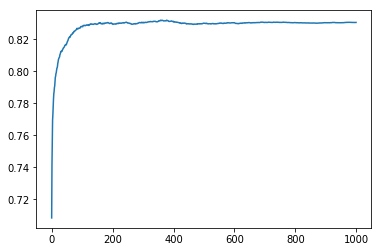

In [50]:
# plt.plot(evals_result['training']['auc'])
plt.plot(evals_result['valid_1']['auc'])

In [21]:
evals_result.keys()

dict_keys(['training', 'valid_1'])